In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from prml.markov_models import CategoricalHMM, GaussianHMM

In [2]:
gaussian_hmm = GaussianHMM(
    initial_proba=np.ones(3) / 3,
    transition_proba=np.array([[0.9, 0.05, 0.05], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]]),
    means=np.array([[0, 0], [2, 10], [10, 5]]),
    covs=np.asarray([np.eye(2) for _ in range(3)]))

In [3]:
seq = gaussian_hmm.draw(100)

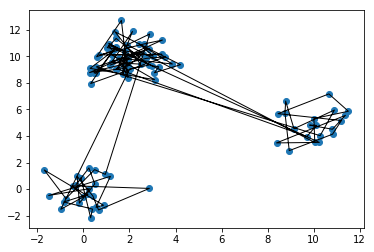

In [4]:
plt.scatter(seq[:, 0], seq[:, 1])
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=1)
plt.show()

In [5]:
posterior = gaussian_hmm.forward_backward(seq)

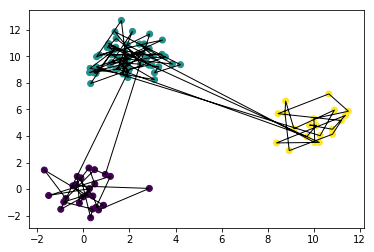

In [6]:
plt.scatter(seq[:, 0], seq[:, 1], c=np.argmax(posterior, axis=-1))
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=1)
plt.show()

In [7]:
categorical_hmm = CategoricalHMM(
    initial_proba=np.ones(2) / 2,
    transition_proba=np.array([[0.95, 0.05], [0.05, 0.95]]),
    means=np.array([[0.2, 0.8], [0.8, 0.2]]))

In [8]:
seq = categorical_hmm.draw(100)

In [9]:
posterior = categorical_hmm.forward_backward(seq)

(0, 1)

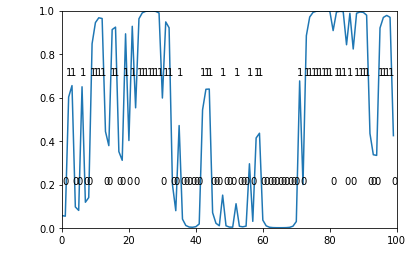

In [10]:
plt.plot(posterior[:, 0])
for i in range(0, len(seq)):
    plt.annotate(str(seq[i]), (i - .75, seq[i] / 2. + 0.2))
plt.xlim(0, len(seq))
plt.ylim(0, np.max(seq))